In [1]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from wittgenstein import RIPPER
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.metrics import (make_scorer, accuracy_score, precision_score,
                             recall_score, f1_score, precision_recall_fscore_support, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# 1 Data Preprocessing

## 1.1 Handling categorical attirbute

In [2]:
def discretize_data(dataset, variables):
    for variable in variables:
        # get the unique variable's values
        var = sorted(dataset[variable].unique())

        # generate a mapping from the variable's values to the number representation
        mapping = dict(zip(var, range(0, len(var) + 1)))

        # add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset


In [3]:
original_dataset = pd.read_csv("data/final_dataset.csv")
original_dataset.head()

,date,year,populous_city,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,771.0,2015.0,1,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1491.0,2017.0,0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1131.0,2016.0,1,42.4190,-83.0393,28.0,31.0,37.0,0.0,0.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1132.0,2016.0,1,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,770.0,2015.0,0,40.4621,-80.0308,2.0,20.0,26.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [4]:
state_cols = [n for n in original_dataset.columns if n.startswith('state')]
state_cols.remove('state_population')
state_one_hot = pd.concat([original_dataset.pop(x) for x in state_cols], axis=1)
state_one_hot = state_one_hot.rename(mapper=lambda x: x[6:], axis='columns')
state_discrete = state_one_hot.idxmax(axis=1).to_frame("state")
original_dataset = pd.concat([original_dataset, state_discrete], axis=1)

variables = ['populous_city', 'party', 'state']
categorical_dataset = discretize_data(original_dataset, variables)
categorical_dataset = categorical_dataset.drop(columns=variables)
categorical_dataset.head()

,date,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,...,povertyPercentage,totalvotes,republicans_ratio,democrats_ratio,state_population,month_x,month_y,populous_city_num,party_num,state_num
0,771.0,2015.0,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,1.0,...,12.3,112261.0,0.452677,0.547323,6611442,5.000000e-01,-0.866025,1,0,14
1,1491.0,2017.0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,1.0,...,10.5,307843.0,0.671644,0.328356,12794679,8.660254e-01,-0.500000,0,1,38
2,1131.0,2016.0,42.4190,-83.0393,28.0,31.0,37.0,0.0,0.0,0.0,...,11.0,310974.0,0.214934,0.785066,9954117,-5.000000e-01,0.866025,1,0,22
3,1132.0,2016.0,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,1.0,...,14.9,277513.0,0.722154,0.277846,687576,-8.660254e-01,0.500000,1,1,8
4,770.0,2015.0,40.4621,-80.0308,2.0,20.0,26.0,0.0,1.0,1.0,...,11.5,148351.0,0.000000,1.000000,12789838,1.224647e-16,-1.000000,0,0,38


In [5]:
labels = categorical_dataset.pop('killed_ratio')
labels = (labels.to_numpy() > 0).astype('int')
dataset = categorical_dataset.to_numpy()

In [6]:
train_set, test_set, train_label, test_label = train_test_split(dataset, labels, stratify=labels, test_size=0.20)

# 2 Utilities for measuring metrics scores

In [7]:
def report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt):
    print('Accuracy train set ', accuracy_score(train_label, train_pred_dt))
    print('Accuracy test set ', accuracy_score(test_label, test_pred_dt))
    print('Precision train set ', precision_score(train_label, train_pred_dt, average='weighted'))
    print('Recall train set ', recall_score(train_label, train_pred_dt, average='weighted'))
    print('F1 score train set ', f1_score(train_label, train_pred_dt, average='weighted'))
    print('Support train set ', precision_recall_fscore_support(train_label, train_pred_dt))

In [8]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                                test_pred,
                                target_names=['No Killed', 'Killed']))

In [9]:
def report_confusion_matrix(test_label, test_pred_dt):
    cm = confusion_matrix(test_label, test_pred_dt)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Killed', 'Killed'])
    disp.plot()
    plt.show()

# 3 Decision Tree

In [10]:
decision_tree = DecisionTreeClassifier()
param_dist = { "criterion": ["gini", "entropy"],
               "max_depth": [2,3,5,6,7,10,12,None],
               "min_samples_split": sp_randint(10, 51),
               "min_samples_leaf": sp_randint(10, 51),
               "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

random_search = RandomizedSearchCV(decision_tree, param_distributions=param_dist,
                                 n_iter=50,
                                 n_jobs=8,
                                 scoring=make_scorer(accuracy_score))
#run the grid search
random_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=50, n_jobs=8,
                   param_distributions={'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09c365d930>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09c39ed390>},
                   scoring=make_scorer(accuracy_score))

In [11]:
print('Best setting parameters ', random_search.cv_results_['params'][0])
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])
best_model = random_search.best_estimator_

Best setting parameters  {'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 22, 'min_samples_split': 19}
Mean and std of this setting  0.8120979386654413 0.0049045049216736095


In [12]:
train_pred_dt = best_model.predict(train_set)
test_pred_dt = best_model.predict(test_set)

In [13]:
report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt)

Accuracy train set  0.847595872671067
Accuracy test set  0.8394009649727426
Precision train set  0.8460612630452131
Recall train set  0.847595872671067
F1 score train set  0.8467715567294166
Support train set  (array([0.89563065, 0.69040448]), array([0.90446062, 0.66903038]), array([0.90002398, 0.6795494 ]), array([145249,  46255]))


In [14]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

   No Killed       0.89      0.90      0.89     36313
      Killed       0.67      0.65      0.66     11564

    accuracy                           0.84     47877
   macro avg       0.78      0.78      0.78     47877
weighted avg       0.84      0.84      0.84     47877


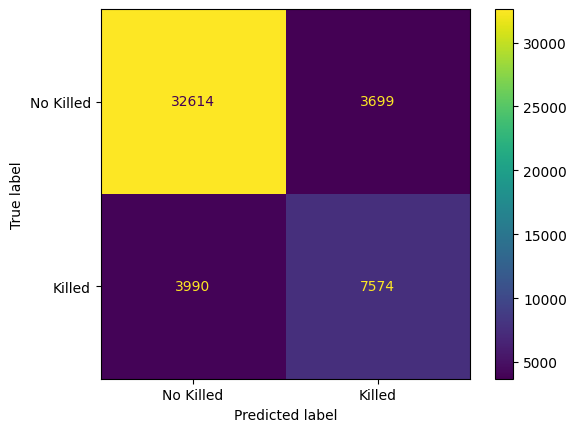

In [15]:
report_confusion_matrix(test_label, test_pred_dt)

# 3 Random Forest

In [17]:
random_forest = RandomForestClassifier(n_estimators=10)
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, train_set.shape[0] + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

grid_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                 n_iter=10,
                                 n_jobs=8,
                                 scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=10), n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09c36567d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09d8afb220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09f3ecfe20>},
                   scoring=make_scorer(accuracy_score))

In [18]:
print('Best setting parameters ', random_search.cv_results_['params'][0])
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])
best_model = random_search.best_estimator_

Best setting parameters  {'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 22, 'min_samples_split': 19}
Mean and std of this setting  0.8120979386654413 0.0049045049216736095


In [19]:
train_pred_dt = best_model.predict(train_set)
test_pred_dt = best_model.predict(test_set)

In [20]:
report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt)

Accuracy train set  0.847595872671067
Accuracy test set  0.8394009649727426
Precision train set  0.8460612630452131
Recall train set  0.847595872671067
F1 score train set  0.8467715567294166
Support train set  (array([0.89563065, 0.69040448]), array([0.90446062, 0.66903038]), array([0.90002398, 0.6795494 ]), array([145249,  46255]))


In [21]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

   No Killed       0.89      0.90      0.89     36313
      Killed       0.67      0.65      0.66     11564

    accuracy                           0.84     47877
   macro avg       0.78      0.78      0.78     47877
weighted avg       0.84      0.84      0.84     47877


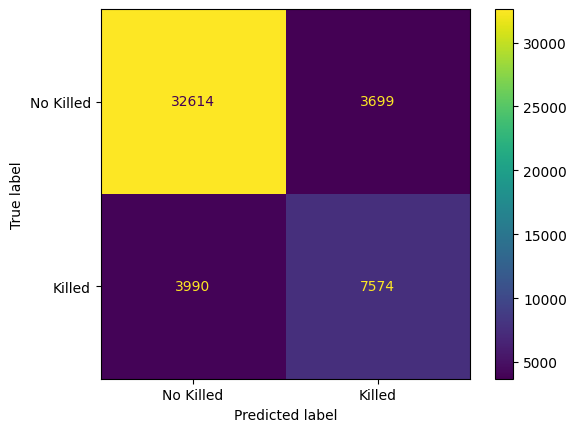

In [22]:
report_confusion_matrix(test_label, test_pred_dt)

# 4 RIPPER

In [23]:
ripper = RIPPER()
param_dist = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}

grid_search = RandomizedSearchCV(ripper, param_distributions=param_dist,
                                 n_iter=10,
                                 n_jobs=8,
                                 scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

/home/filippo/uni/DM/DataMiningProject/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print('Best setting parameters ', random_search.cv_results_['params'][0])
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])
best_model = random_search.best_estimator_

In [ ]:
train_pred_dt = best_model.predict(train_set)
test_pred_dt = best_model.predict(test_set)

In [ ]:
report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt)

In [ ]:
report_scores(test_label, test_pred_dt)

In [ ]:
report_confusion_matrix(test_label, test_pred_dt)

# 5 K-nn

In [24]:
knn = KNeighborsClassifier(algorithm='ball_tree', metric='minkowski')
param_dist = {"n_neighbors": [1, 3, 5, 7]}

grid_search = RandomizedSearchCV(knn, param_distributions=param_dist,
                                 n_iter=4,
                                 n_jobs=8,
                                 scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=KNeighborsClassifier(algorithm='ball_tree'),
                   n_iter=4, n_jobs=8,
                   param_distributions={'n_neighbors': [1, 3, 5, 7]},
                   scoring=make_scorer(accuracy_score))

In [25]:
print('Best setting parameters ', random_search.cv_results_['params'][0])
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])
best_model = random_search.best_estimator_

Best setting parameters  {'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 22, 'min_samples_split': 19}
Mean and std of this setting  0.8120979386654413 0.0049045049216736095


In [26]:
train_pred_dt = best_model.predict(train_set)
test_pred_dt = best_model.predict(test_set)

In [27]:
report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt)

Accuracy train set  0.847595872671067
Accuracy test set  0.8394009649727426
Precision train set  0.8460612630452131
Recall train set  0.847595872671067
F1 score train set  0.8467715567294166
Support train set  (array([0.89563065, 0.69040448]), array([0.90446062, 0.66903038]), array([0.90002398, 0.6795494 ]), array([145249,  46255]))


In [28]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

   No Killed       0.89      0.90      0.89     36313
      Killed       0.67      0.65      0.66     11564

    accuracy                           0.84     47877
   macro avg       0.78      0.78      0.78     47877
weighted avg       0.84      0.84      0.84     47877


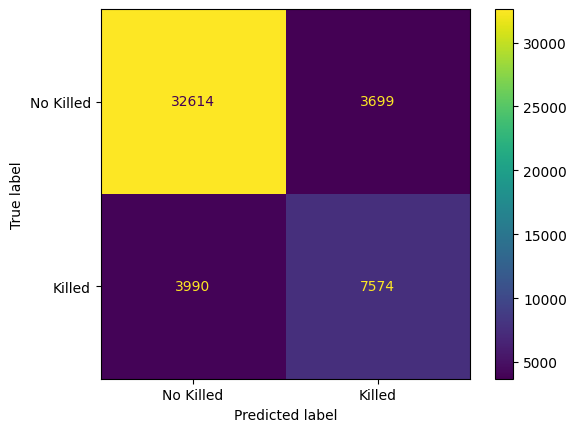

In [29]:
report_confusion_matrix(test_label, test_pred_dt)

# 6 Naive Bayes

In [30]:
naiveBayes = GaussianNB()

#run the grid search
naiveBayes.fit(train_set, train_label)

GaussianNB()

In [31]:
train_pred_dt = naiveBayes.predict(train_set)
test_pred_dt = naiveBayes.predict(test_set)

In [32]:
report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt)


Accuracy train set  0.7420314980365945
Accuracy test set  0.7442613363410406
Precision train set  0.6626894886401873
Recall train set  0.7420314980365945
F1 score train set  0.6735195380944501
Support train set  (array([0.76416504, 0.34403806]), array([0.95443686, 0.07504054]), array([0.84876815, 0.12320744]), array([145249,  46255]))


In [33]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

   No Killed       0.76      0.96      0.85     36313
      Killed       0.36      0.08      0.13     11564

    accuracy                           0.74     47877
   macro avg       0.56      0.52      0.49     47877
weighted avg       0.67      0.74      0.68     47877


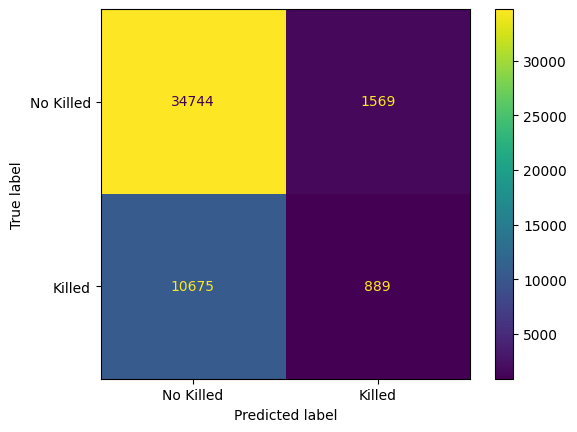

In [34]:
report_confusion_matrix(test_label, test_pred_dt)

# 7 SVC

In [36]:
svc = SVC()
param_dist = {"C": [1e-1, 1, 10],
              "kernel": ["rbf", "linear", "poly"]}


grid_search = RandomizedSearchCV(svc, param_distributions=param_dist,
                                 n_iter=4,
                                 n_jobs=8,
                                 scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

KeyboardInterrupt: 

In [ ]:
print('Best setting parameters ', random_search.cv_results_['params'][0])
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])
best_model = random_search.best_estimator_

In [ ]:
train_pred_dt = best_model.predict(train_set)
test_pred_dt = best_model.predict(test_set)

In [ ]:
report_metrics_best_estimator(train_label, train_pred_dt, test_label, test_pred_dt)

In [ ]:
report_scores(test_label, test_pred_dt)

In [ ]:
report_confusion_matrix(test_label, test_pred_dt)

# 8 Neural Network